# ACA centroiding/ Dynamic Background/ Validations#

In [1]:
#%matplotlib inline
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table
import astropy.units as u
from kadi import events
from mica.archive import aca_l0
import Ska.engarchive.fetch as fetch
from chandra_aca import transform
from Chandra.Time import DateTime
import Ska.Numpy
from mica import quaternion
import numpy.ma as ma
import collections
from Ska.Matplotlib import plot_cxctime
from copy import deepcopy
from importlib import reload
import sys

In [2]:
sys.path.append("../py")
#local imports
from bgd_classes import *
import sim_aca_l0 as siml0
import centroids as cntr
import myplot as mplt

### Contents ###

* Simulate <code>IMGROW0</code>, <code>IMGCOL0</code> response to dither.


* Simulate two stars, with magnitudes of 8.2 mag and 10.2 mag, and __no hot pixels__, using all three background prescritions <code>(StandardBgd, DynamBgd_Median, SynamBgd_SigmaClip).</code>

### <code>IMGROW0</code>, <code>IMGCOL0</code> response to dither###

__Note 1.__ This is relevant only for simulations. Some prescription of dither needs to be introduced, to move around the ACA window and simulate the on-the-fly dynamic background construction and centroiding. For the real data, <code>IMGROW0</code>, <code>IMGCOL0</code> are read from the <code>aca_l0</code> file.

__Note 2.__ In reality, this response depends likely on the next anticipated centroid position because <code>IMGROW0</code>, <code>IMGCOL0</code> time behaviour differs among the slots. - I am using difference between real centroids and yaw/pitch? If I used the difference between the computed centroids and yaw/pitch then disturbing the centroids by the hot pixels would be accounted for.

Simulated <code>IMGROW0</code> and <code>IMGCOL0</code> are defined so that they respond to the dither pathern (yaw, pitch). Here this response is defined so that the difference between yaw and <code>IMGROW0</code>, and pitch and <code>IMGCOL0</code> is always < 1 pixel to keep star image near the center of the 8x8 window.

Below, this algorithm is checked against real data (obsid 50804).

In [3]:
obsid = 50804
slot = 3
dwell = events.dwells.filter(obsid=obsid)[0]
slot_data = aca_l0.get_slot_data(dwell.start, dwell.stop, slot=slot)
time = slot_data['TIME']
row0 = slot_data['IMGROW0']
col0 = slot_data['IMGCOL0']

In [4]:
# Dither parameters, ACIS
ampl_yaw = 8. * u.arcsec
ampl_pitch = 8. * u.arcsec
pxsize = 5. * u.arcsec # per pixel
period_yaw = 1000.0 # sec
period_pitch = 707.1 # sec

# "Fit" parameters (depend on obsid and slot)
phase_yaw = 0.9 # in 2 pi
phase_pitch = 0.75 # in 2 pi
delta = 0.25 # px

yaw = ampl_yaw / pxsize * np.sin(2 * np.pi * time / period_yaw + 2 * np.pi * phase_yaw)
pitch = ampl_pitch / pxsize * np.sin(2 * np.pi * time / period_pitch + 2 * np.pi * phase_pitch)

sim_row0 = np.array(np.round(yaw - delta), dtype=np.int)
sim_col0 = np.array(np.round(pitch - delta), dtype=np.int)

print(np.sum(yaw - sim_row0 > 1), np.sum(pitch - sim_col0 > 1))

0 0


<IPython.core.display.Javascript object>


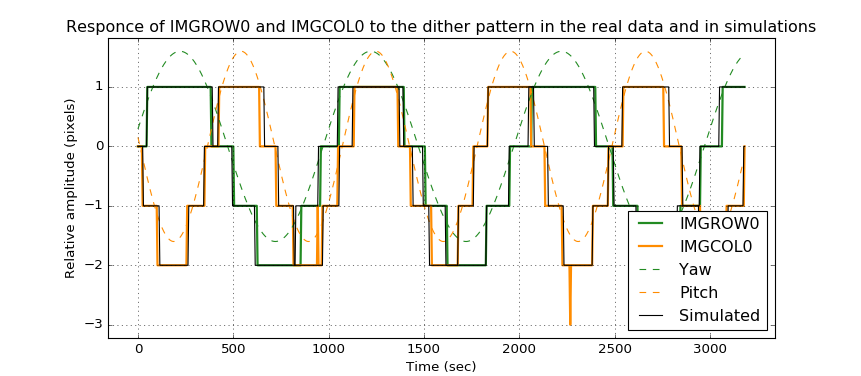

In [5]:
#plt.figure(figsize=(14, 6))

plt.plot(time - time[0], row0 - row0[0], 'forestgreen', lw=2, label='IMGROW0')
plt.plot(time - time[0], col0 - col0[0], 'darkorange', lw=2, label='IMGCOL0')
plt.plot(time - time[0], yaw, 'forestgreen', ls='--', label='Yaw')
plt.plot(time - time[0], pitch, 'darkorange', ls='--', label='Pitch')

plt.plot(time - time[0], sim_row0, 'k')
plt.plot(time - time[0], sim_col0, 'k', label='Simulated')

plt.grid()
plt.legend(loc='lower right')
plt.xlabel("Time (sec)")
plt.ylabel("Relative amplitude (pixels)")
plt.title('Responce of IMGROW0 and IMGCOL0 to the dither pattern in the real data and in simulations');
plt.margins(0.05)

### No hot pixels ###

Simulate two stars, with magnitudes of 8.2 mag and 10.2 mag, and __no hot pixels__, using all three background prescritions <code>(StandardBgd, DynamBgd_Median, SynamBgd_SigmaClip).</code>

In [6]:
img_size = 8 # pixels
delta_t = 4.1 # sec
integ = 1.696 # sec
nframes = 1000

In [7]:
# Define dither parameters
ampl, period = siml0.dither_acis()
phase_yaw = 0.9 # in 2 pi
phase_pitch = 0.75 # in 2 pi
phase = [phase_yaw, phase_pitch] # in 2 * np.pi
delta = 0.25 # px

In [8]:
# Average background amd kwargs for simulated aca_l0 data
bgdavg = 10. # pixel value
kwargs = {'nframes':nframes, 'delta_t':delta_t, 'integ':integ, 'bgdavg':bgdavg,
          'ampl':ampl, 'period':period, 'phase':phase, 'delta':delta}
# Example 2: with hot pixel sampled only after the first t = 500sec
# kwargs['phase'] = 0.

In [9]:
ndeque = 5 # number of vals in deque before we start to popleft()
slot = 0

In [10]:
mags = [10.2, 8.2] # mag

init_kwargs = [{}, {'img_size':img_size, 'bgdavg':bgdavg, 'ndeque':ndeque},
                   {'img_size':img_size, 'bgdavg':bgdavg, 'ndeque':ndeque}]

rows_all = []

for mag in mags:
    
    kwargs['mag'] = mag
    
    np.random.seed(42)
    slot_data, true_centroids = siml0.simulate_aca_l0(img_size, hot_pixels=None, **kwargs)
    
    for i, Bgd_Class in enumerate([StandardBgd, DynamBgd_Median, DynamBgd_SigmaClip]):
        bgd_object = Bgd_Class(**init_kwargs[i]) 
        rows = cntr.centroids(slot, slot_data, img_size, bgd_object, sim=True, hot_pixels=None, nframes=nframes)
        for row in rows:
            row['mag'] = mag
            row['bgd_type'] = bgd_object.__class__.__name__
            row['true_row'] = true_centroids[0]
            row['true_col'] = true_centroids[1]
            y_pixels = true_centroids[0] + row['row0']
            z_pixels = true_centroids[1] + row['col0']
            true_yanzan = transform.pixels_to_yagzag(y_pixels, z_pixels)
            row['true_yan'] = true_yanzan[0]
            row['true_zan'] = true_yanzan[1]
            if isinstance(bgd_object, (DynamBgd_Median, DynamBgd_SigmaClip)):
                row['ndeque'] = ndeque
            else:
                row['ndeque'] = None
            rows_all.append(row)
        
t = Table(rows_all)

Slot = 0
Slot = 0
Slot = 0
Slot = 0
Slot = 0
Slot = 0


In [14]:
print(t.colnames)
print()
print(t['bgd_type', 'mag', 'ndeque'])
print()

['bgd_type', 'bgdimg', 'col', 'col0', 'deque_dict', 'imgraw', 'mag', 'ndeque', 'row', 'row0', 'slot', 'time', 'true_col', 'true_row', 'true_yan', 'true_zan', 'yan', 'zan']

     bgd_type      mag  ndeque
------------------ ---- ------
       StandardBgd 10.2   None
   DynamBgd_Median 10.2      5
DynamBgd_SigmaClip 10.2      5
       StandardBgd  8.2   None
   DynamBgd_Median  8.2      5
DynamBgd_SigmaClip  8.2      5



In [15]:
# 'Dither' check
row0, col0, yaw, pitch = siml0.get_row0col0_yawpitch(t['time'][0],
                                                     ampl=ampl, period=period, phase=phase)
print(np.sum(yaw - row0 > 1), np.sum(pitch - col0 > 1))

0 0


### Visualisation of the results ###

* Derived vs. 'true' coordinates

* Difference between derived and 'true' coordinates

* Residuals (Bright star - Faint star)

* Derived background images

__Plot derived and 'true' coordinates__

<IPython.core.display.Javascript object>


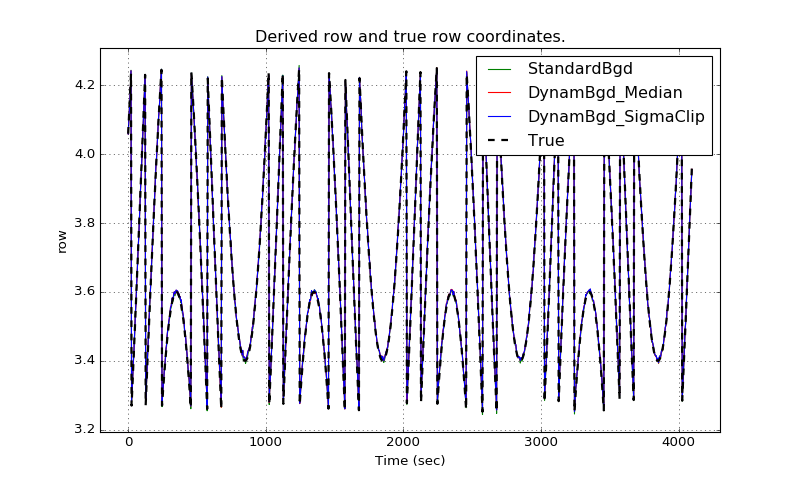

<IPython.core.display.Javascript object>


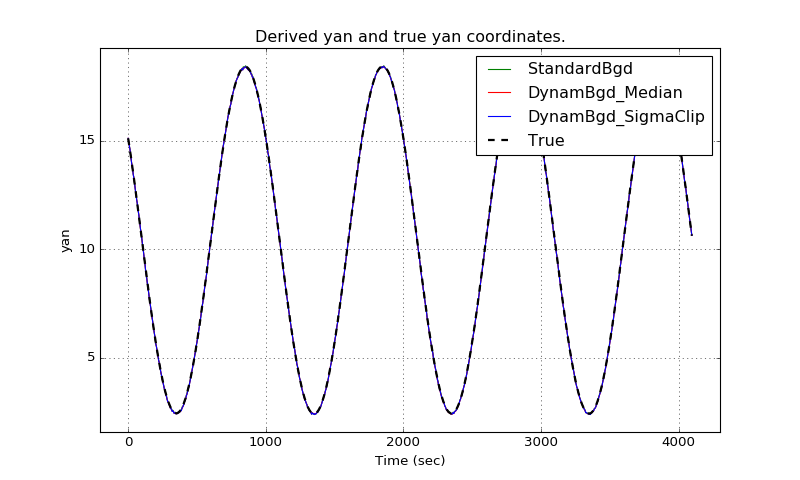

In [16]:
mplt.plot_coords(slot, t, 'row') # computed 'row' coordinate (between 0 and 8)
mplt.plot_coords(slot, t, 'yan') # computed 'yan' coordinate

__Plot difference between computed and 'true' coordinates__

<IPython.core.display.Javascript object>


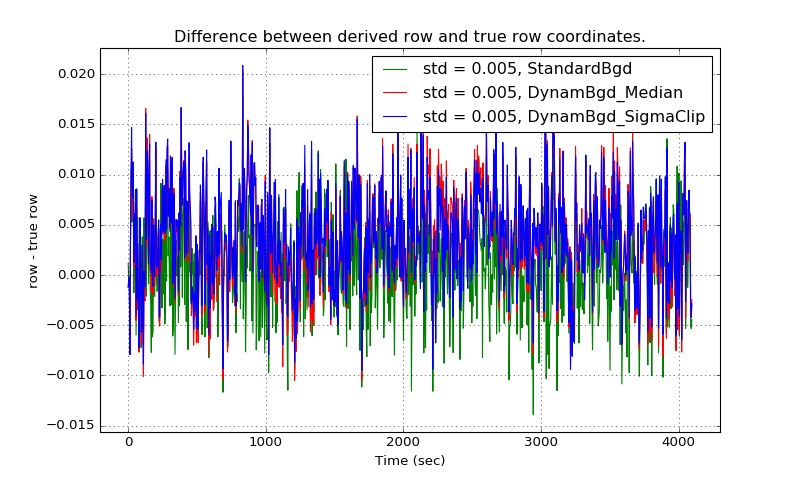

<IPython.core.display.Javascript object>


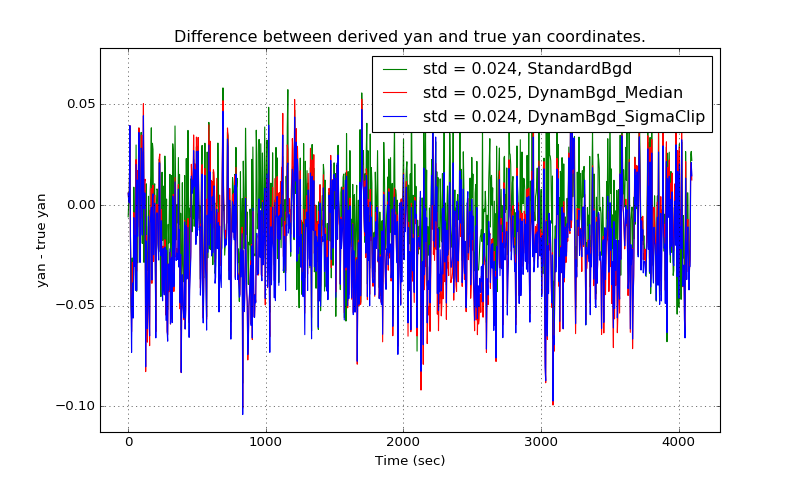

In [17]:
mplt.plot_coords_excess(slot, t, 'row')
mplt.plot_coords_excess(slot, t, 'yan')

__Plot residuals (Bright - Faint star)__

<IPython.core.display.Javascript object>


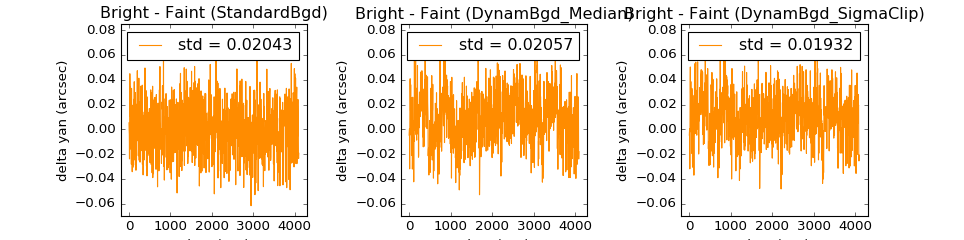

In [18]:
faint = t['mag'] == 10.2
bright = t['mag'] == 8.2

key = 'yan'

fig = plt.figure(figsize=(13, 3))

ylim = (-0.07, 0.085)

methods = ['StandardBgd', 'DynamBgd_Median', 'DynamBgd_SigmaClip']

for i, method in enumerate(methods):
    plt.subplot(1, 3, i + 1)
    d_ang = t[bright][key][i] - t[faint][key][i]
    plt.plot(t['time'][0], d_ang, color='Darkorange',
             label='std = {:.5f}'.format(np.std(d_ang - np.median(d_ang))))
    plt.title('Bright - Faint (' + method + ')')    
    plt.xlabel('Time (sec)')
    plt.ylabel('delta {} (arcsec)'.format(key))
    plt.legend()
    plt.margins(0.05)
    plt.ylim(ylim)
    
plt.subplots_adjust(wspace=0.5)

__Plot derived background images__

* <span style="color:blue">Blue patch</span> - region eventually sampled due to the dither
* <span style="color:red">8x8 patch</span> - bgd region corresponding to a current frame (edge pixel values + current <code>bgdavg</code> 'inside' the edge)

Format of the titles is 'time: imgrow0, imgcol0'
Plot bgd imaged from 0 to 50
Method: DynamBgd_Median


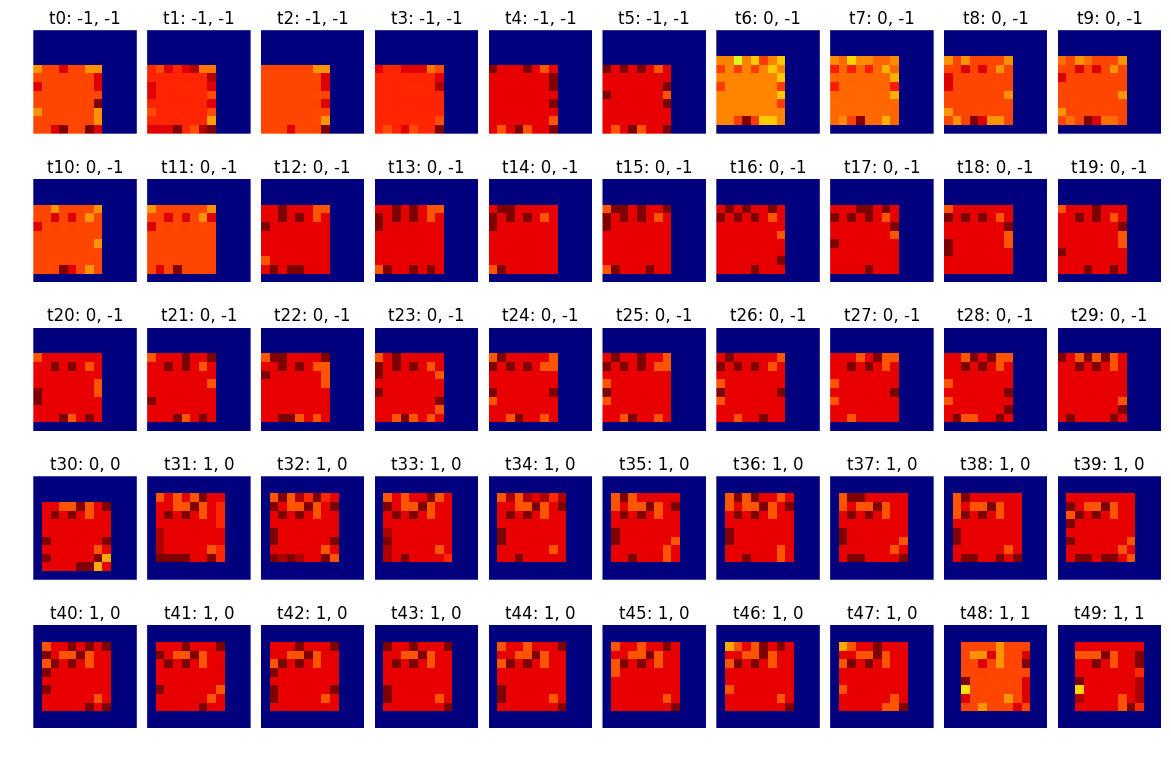

In [23]:
%matplotlib inline
mplt.plot_bgd_images(t, slot=0, n_start=0, n_stop=50, img_size=img_size, method='DynamBgd_Median')

* <span style="color:blue">Blue patch</span> - region eventually sampled due to the dither
* <span style="color:red">Red patch</span> - 'edge' pixels that have been sampled at time t (this region increases with t)

Format of the titles is 'time: imgrow0, imgcol0'
Plot frames from 0 to 50
Method: DynamBgd_Median, ndeque = 5


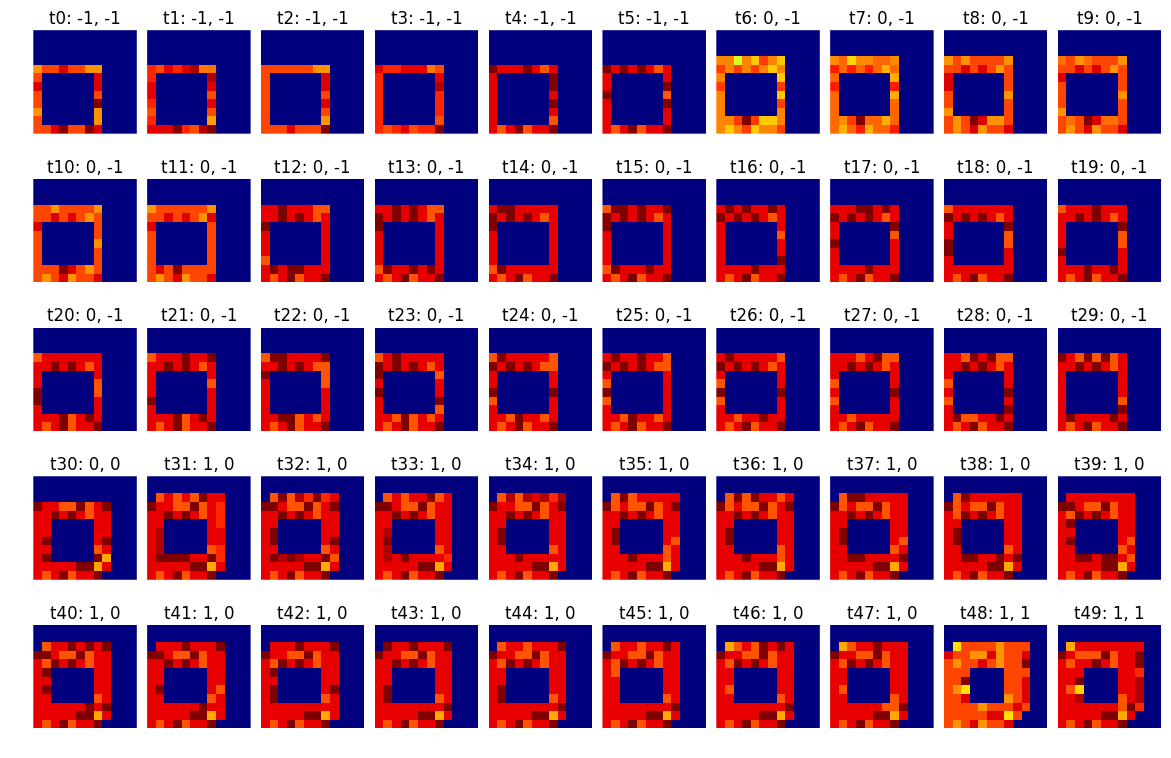

In [24]:
mplt.plot_bgd_patches(t, slot=0, n_start=0, n_stop=50, img_size=img_size, method='DynamBgd_Median')

Format of the titles is 'time: imgrow0, imgcol0'
Plot frames from 200 to 250
Method: DynamBgd_Median, ndeque = 5


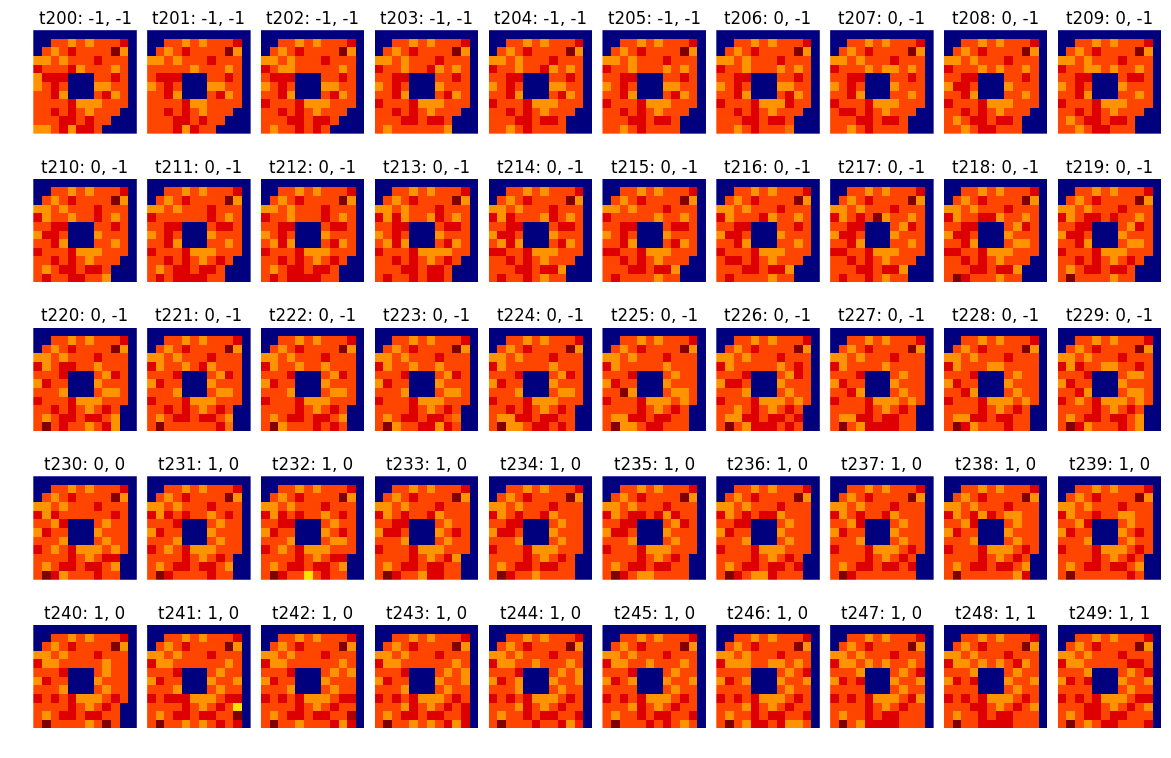

In [25]:
mplt.plot_bgd_patches(t, slot=0, n_start=200, n_stop=250, img_size=img_size, method='DynamBgd_Median')

Format of the titles is 'time: imgrow0, imgcol0'
Plot frames from 950 to 1000
Method: DynamBgd_Median, ndeque = 5


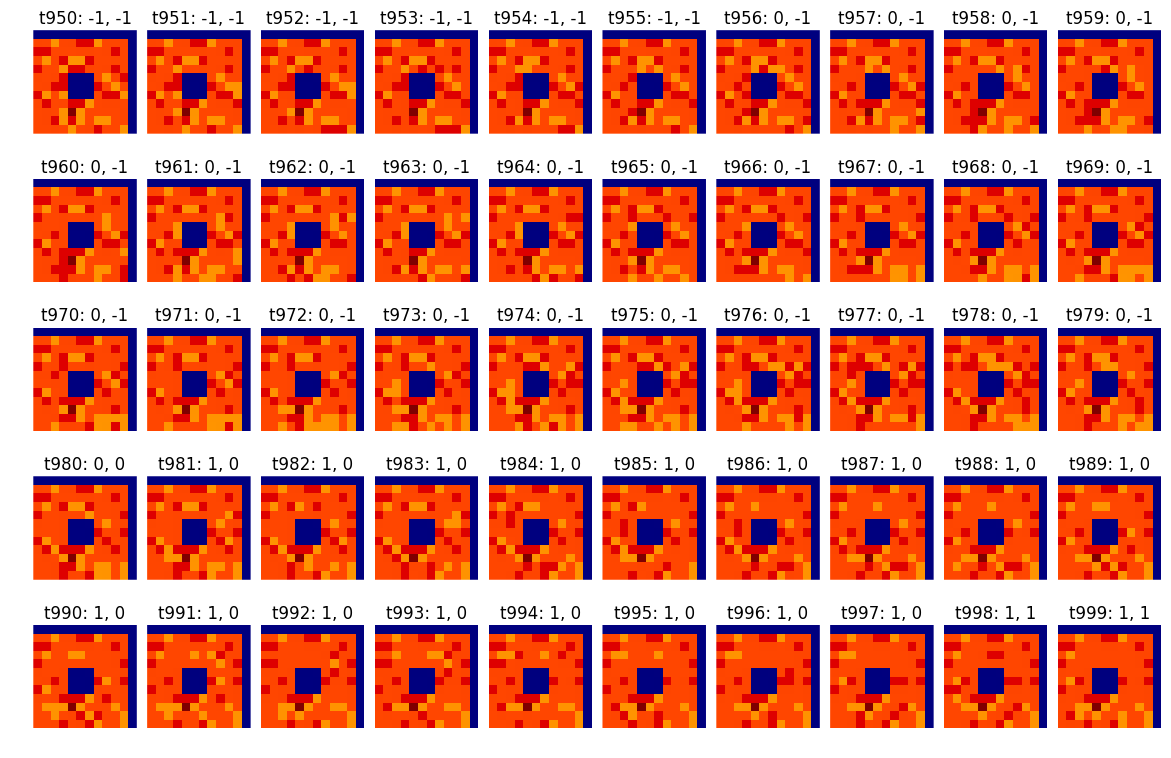

In [26]:
n_start = nframes - 50
mplt.plot_bgd_patches(t, slot=0, n_start=n_start, n_stop=nframes, img_size=img_size, method='DynamBgd_Median')

In [34]:
ok = t['bgd_type'] == 'DynamBgd_Median'
ok1 = t['slot'] == 0
lens = []

for key, val in t[ok * ok1]['deque_dict'][0][-1].items():
    lens.append(len(val))
    
print("Min deque length = {}, Max deque length = {}".format(np.min(lens), np.max(lens)))

Min deque length = 5, Max deque length = 5
